In [1]:
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


# Step1. 검증용 데이터셋 준비


 Google OCR API, keras-ocr, Tesseract 의 기능차이를 구분하기 위한 데이터셋을 준비한다.
 
 - 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터
 - 테스트용 이미지는 아무리 많아도 20장

ocr_python/data 폴더 안에 test_1~test_5 이미지를 모았다. <br>
- test_1 : 다량의 문장과 이미지가 들어간 데이터
- test_2 : 변형없는 정자체의 문장민 들어있는 데이터
- test_3 : 노이즈가 포함된 텍스트 이미지 데이터
- test_4, test_5 : 현실 이미지 

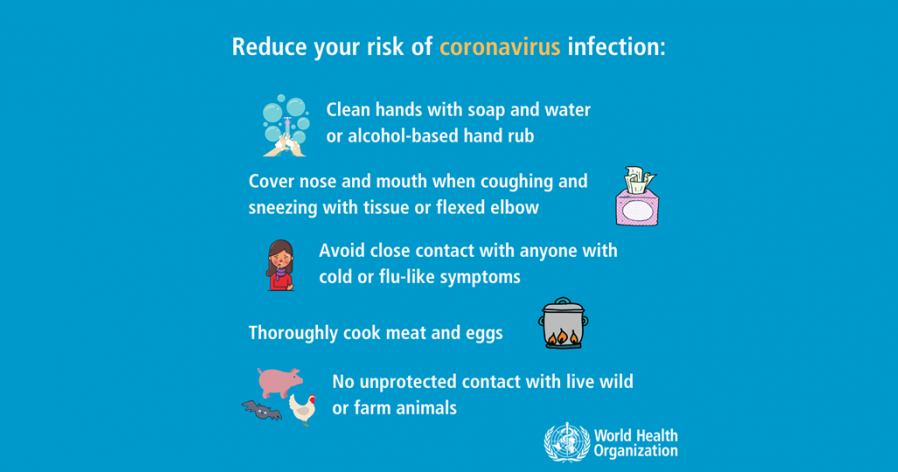

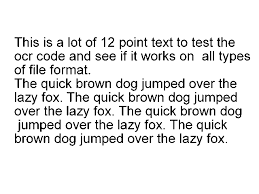 

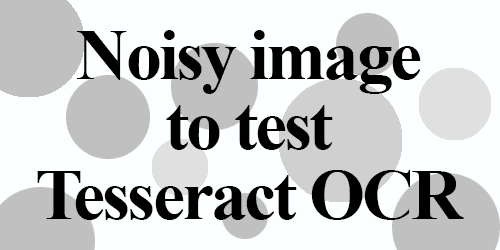

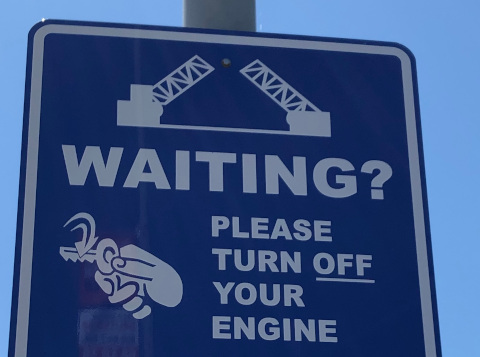

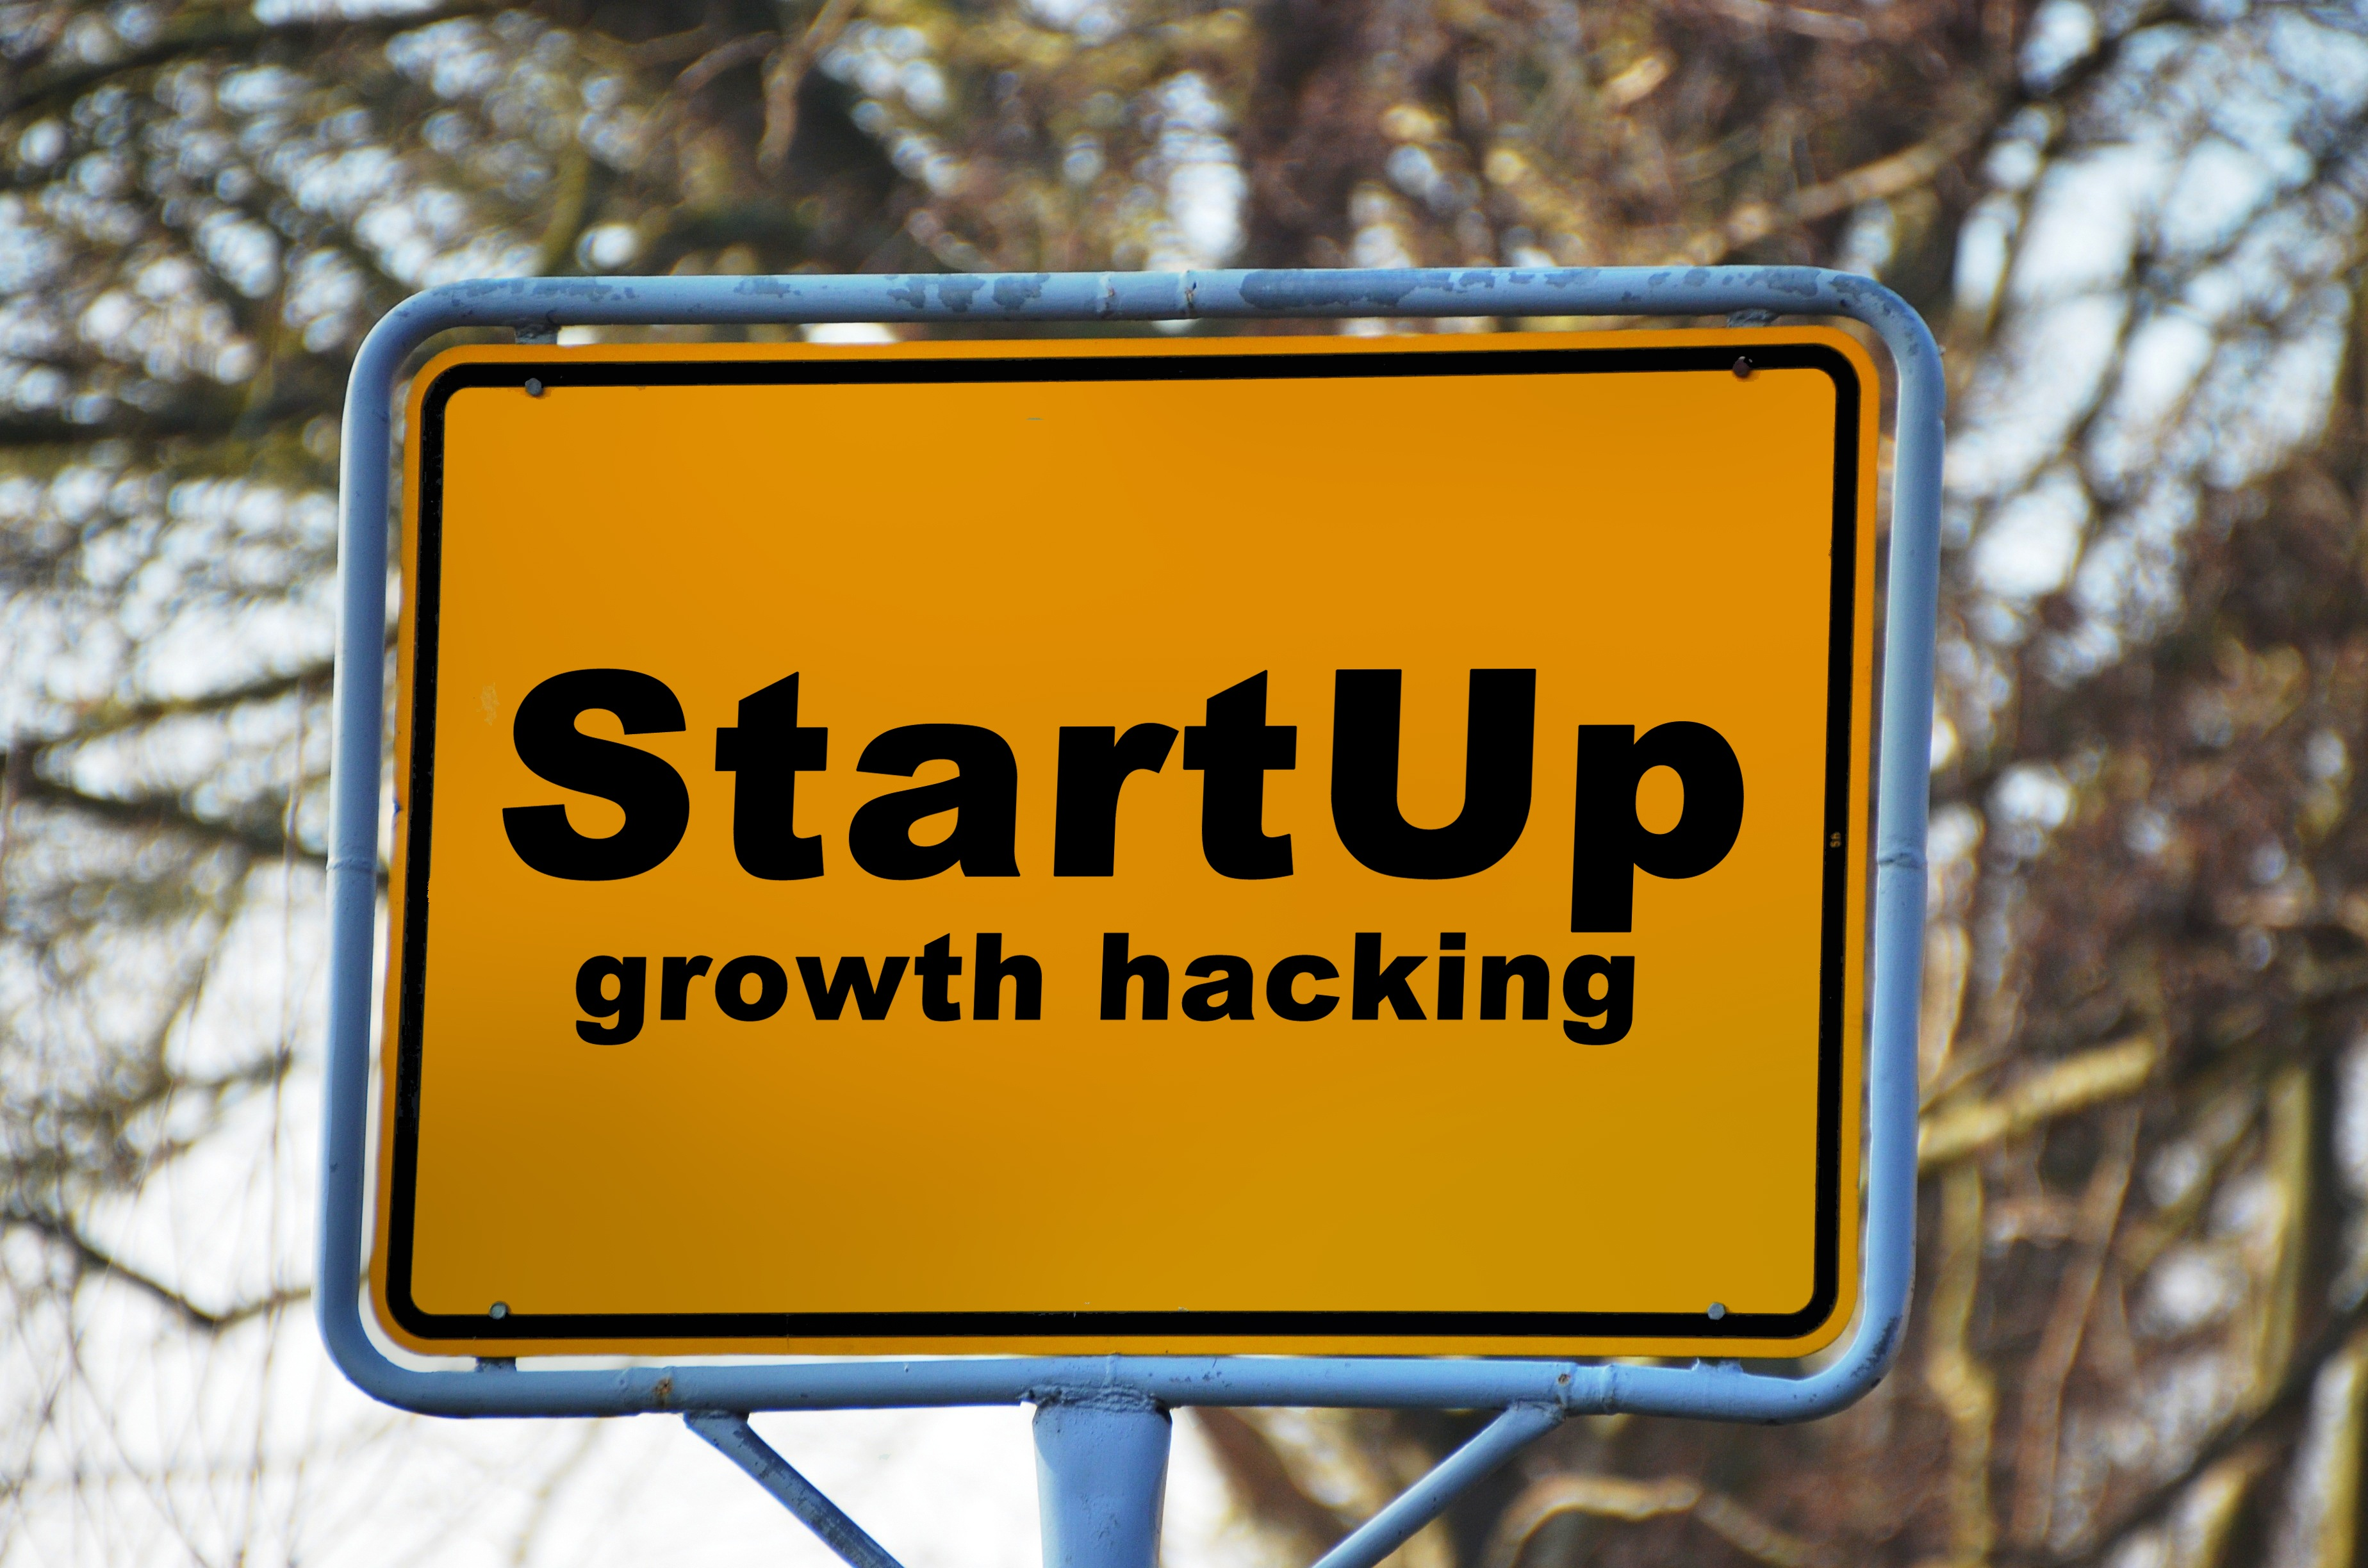

# Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)


In [2]:
# keras-ocr
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [4]:
keras_ocr.tools.read('~/aiffel/ocr_python/data/test_1.png')

AssertionError: Could not find image at path: ~/aiffel/ocr_python/data/test_1.png

In [7]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
# url은 파일의 경로로 대체할 수도 있다. 
import os
data_dir = os.getenv('HOME')+'/aiffel/ocr_python/data/'


image_urls = [
    data_dir + 'test_1.png', 
    data_dir + 'test_2.png',
    data_dir + 'test_3.png',
    data_dir + 'test_4.jpeg',
    data_dir + 'test_5.jpg'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

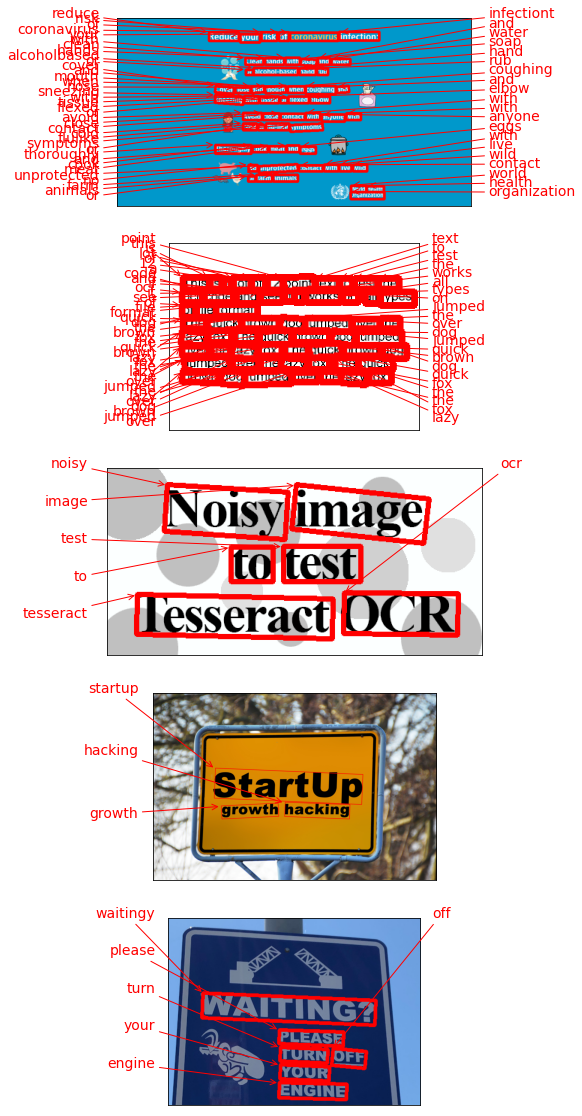

In [8]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

모든 텍스트가 제대로 검출된 것을 확인할 수 있다.

In [9]:
#tesseract
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [11]:


# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


img_file_paths = [
    data_dir + 'test_1.png', 
    data_dir + 'test_2.png',
    data_dir + 'test_3.png',
    data_dir + 'test_4.jpeg',
    data_dir + 'test_5.jpg'
]  #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

for img_file_path in img_file_paths : 
    cropped_image_path_list = crop_word_regions(img_file_path, data_dir)
    # 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
    recognize_images(cropped_image_path_list)
    print("-------------")

/aiffel/aiffel/ocr_python/data/0000.png
/aiffel/aiffel/ocr_python/data/0001.png
/aiffel/aiffel/ocr_python/data/0002.png
/aiffel/aiffel/ocr_python/data/0003.png
/aiffel/aiffel/ocr_python/data/0004.png
/aiffel/aiffel/ocr_python/data/0005.png
/aiffel/aiffel/ocr_python/data/0006.png
/aiffel/aiffel/ocr_python/data/0007.png
/aiffel/aiffel/ocr_python/data/0008.png
/aiffel/aiffel/ocr_python/data/0009.png
/aiffel/aiffel/ocr_python/data/0010.png
/aiffel/aiffel/ocr_python/data/0011.png
/aiffel/aiffel/ocr_python/data/0012.png
/aiffel/aiffel/ocr_python/data/0013.png
/aiffel/aiffel/ocr_python/data/0014.png
/aiffel/aiffel/ocr_python/data/0015.png
/aiffel/aiffel/ocr_python/data/0016.png
/aiffel/aiffel/ocr_python/data/0017.png
/aiffel/aiffel/ocr_python/data/0018.png
/aiffel/aiffel/ocr_python/data/0019.png
/aiffel/aiffel/ocr_python/data/0020.png
/aiffel/aiffel/ocr_python/data/0021.png
/aiffel/aiffel/ocr_python/data/0022.png
/aiffel/aiffel/ocr_python/data/0023.png
/aiffel/aiffel/ocr_python/data/0024.png


확인 결과,
- 비슷하게 생긴 대소문자를 구분하지 못하고 있다. 
- 일부 단어가 부정확하게 검출되고 있다.

In [12]:
#Google OCR API
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [13]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
path = data_dir + 'test_1.png'
#path = # [[YOUR IMAGE FILE PATH]]   

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

total 2561768
drwxr-xr-x 2 root root       4096 Feb 14 03:01  activation
drwxr-xr-x 4 root root       4096 Feb 22 07:44  bert_qna
drwxr-xr-x 4 root root       4096 Jan 11 05:06  camera_sticker
drwxr-xr-x 4 root root       4096 Jan 12 03:41  cat_vs_dog
drwxr-xr-x 2 root root       4096 Feb 10 01:09  chest_xray
-rw-r--r-- 1 root root     575013 Feb 15 09:57 'CYFAR-10 이미지.ipynb'
drwxr-xr-x 2 root root       4096 Jan  3 01:22  data_preprocess
drwxr-xr-x 4 root root       4096 Dec 31 05:31  data_represent
drwxr-xr-x 2 root root       4096 Jan  5 03:11  data_visualization
drwxr-xr-x 4 root root       4096 Feb 15 06:50  dcgan_newimage
-rw-r--r-- 1 root root 2618859090 Feb 15 10:06  dcgan_newimage.zip
drwxr-xr-x 3 root root       4096 Dec 29 03:13  ftext
drwxr-xr-x 4 root root       4096 Feb  3 00:48  human_segmentation
drwxr-xr-x 2 root root       4096 Feb 25 03:13  information_theory
-rw-r--r-- 1 root root     122558 Jan 27 12:32 '네이버 영화리뷰 감성분석 도전하기.ipynb'
-rw-r--r-- 1 root root      78590 F

In [14]:
path = data_dir + 'test_2.png'
detect_text(path)

Texts:

"This is a lot of 12 point text to test the
ocr code and see if it works on all types
of file format.
The quick brown dog jumped over the
lazy fox. The quick brown dog jumped
over the lazy fox. The quick brown dog
jumped over the lazy fox. The quick
brown dog jumped over the lazy fox.
"

"This"

"is"

"a"

"lot"

"of"

"12"

"point"

"text"

"to"

"test"

"the"

"ocr"

"code"

"and"

"see"

"if"

"it"

"works"

"on"

"all"

"types"

"of"

"file"

"format."

"The"

"quick"

"brown"

"dog"

"jumped"

"over"

"the"

"lazy"

"fox."

"The"

"quick"

"brown"

"dog"

"jumped"

"over"

"the"

"lazy"

"fox."

"The"

"quick"

"brown"

"dog"

"jumped"

"over"

"the"

"lazy"

"fox."

"The"

"quick"

"brown"

"dog"

"jumped"

"over"

"the"

"lazy"

"fox."
bounds: (207,133),(226,133),(226,142),(207,142)


In [15]:
path = data_dir + 'test_3.png'
detect_text(path)

Texts:

"Noisy image
to test
Tesseract OCR
"

"Noisy"

"image"

"to"

"test"

"Tesseract"

"OCR"
bounds: (312,170),(463,170),(463,219),(312,219)


In [16]:
path = data_dir + 'test_4.jpeg'
detect_text(path)

Texts:

"StartUp
growth hacking
"

"StartUp"

"growth"

"hacking"
bounds: (1718,1438),(2551,1438),(2551,1631),(1718,1631)


In [17]:
path = data_dir + 'test_5.jpg'
detect_text(path)

Texts:

"WAITING?
PLEASE
TURN OFF
YOUR
ENGINE
"

"WAITING?"

"PLEASE"

"TURN"

"OFF"

"YOUR"

"ENGINE"
bounds: (213,316),(337,319),(336,341),(212,338)


대소문자를 

# Step3. 테스트 결과 정리


#### 1. keras-ocr,

- 전반적으로 대부분의 글자를 감지하였음.
- 대신 대문자를 구분하지 못함. 

#### 2. Tesseract, 

- keras-ocr보단 정확도가 떨어짐
- 비슷한 알파벳의 대소문자를 구분하지 못함.

#### 3. Google OCR API

- 정확도가 매우 높음
- 대소문자를 구분하는 등 모든 글자를 글자 인식함. 


# Step4. 결과 분석과 결론 제시


아무래도 구글에서 만든 모델이 가장 정확도가 높은것으로 보인다. <br>
그 다음으로는 keras-ocr도구가 정확도가 높으며, 마지막으로 tesseract 순이다. 

영미권에서 시각장애인들을 위한 쇼핑보조 어플을 만들기 위해선 가장 높은 정확도가 필요하므로 구글 OCR을 활용하는 것이 바람직 할 것이다. <br> 하지만 비용문제가 가장 크므로 Tesseract를 기반으로 학습하여 나만의 OCR을 만들고 서버를 구축하여 API를 호출하는 것이 비용적인 측면에서 싸게 먹힐 것이다. 

제대로된 학습이 이루어지기 전까진 import만으로 어느정도의 성능을 보장하는 keras-ocr를 활용하는 것이 좋을 것이라고 생각된다.

# 마무리

이번 과정에서 대표적인 OCR 도구 3가지를 사용하는 방법에 대해 공부하였다. 

이를 tuning하여 자신만의 OCR을 만들 수 있느 방법을 공부해봐야할 것 같다.